Non-vectorized 2-layer Network Time: 17.160681 seconds
Vectorized 2-layer Network Time: 0.220604 seconds
Cost from non-vectorized: 0.672960
Cost from vectorized: 0.673031
The costs are effectively the same.


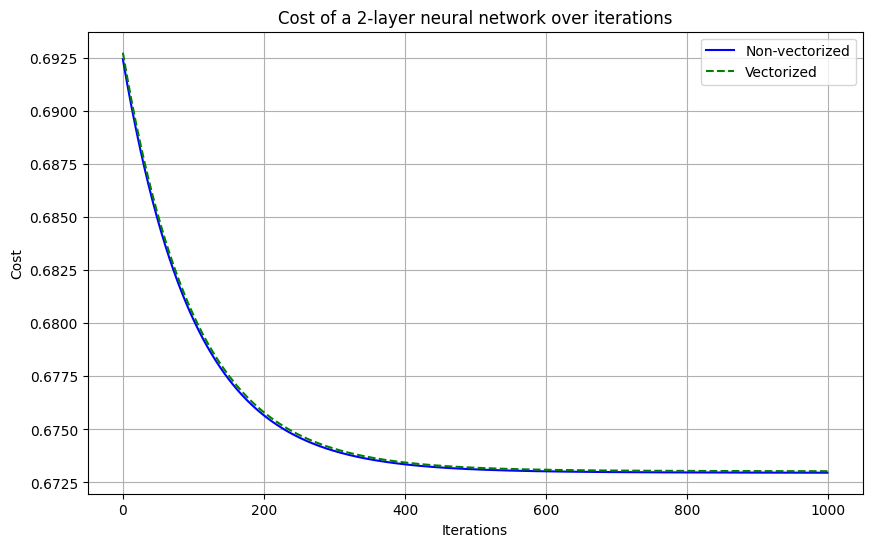

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Set the random seed
np.random.seed(42)

# Example data for comparison (5 features, 100 examples)
X = np.random.rand(5, 100)  # 5 features, 100 examples
y = np.random.randint(0, 2, (1, 100))  # Random binary labels (0 or 1)

n_x, m = X.shape  # Number of input features and number of examples
n_h = 4  # Number of neurons in the hidden layer
learning_rate = 0.01
iterations = 1000

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(A):
    return A * (1 - A)

def non_vectorized_2_layer_network(X, y, n_x, n_h, m, learning_rate, iterations):
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(1, n_h) * 0.01
    b2 = np.zeros((1, 1))

    costs = []

    for iter in range(iterations):
        J = 0  # Cost initialization
        dW1, db1, dW2, db2 = np.zeros_like(W1), np.zeros_like(b1), np.zeros_like(W2), np.zeros_like(b2)

        for i in range(m):
            x_i = X[:, i].reshape(n_x, 1)
            y_i = y[:, i].reshape(1, 1)

            Z1 = W1 @ x_i + b1
            A1 = sigmoid(Z1)
            Z2 = W2 @ A1 + b2
            A2 = sigmoid(Z2)

            J += - (y_i * np.log(A2) + (1 - y_i) * np.log(1 - A2))

            dZ2 = A2 - y_i
            dW2 += dZ2 @ A1.T
            db2 += dZ2

            dZ1 = (W2.T @ dZ2) * sigmoid_derivative(A1)
            dW1 += dZ1 @ x_i.T
            db1 += dZ1

        J /= m
        dW1 /= m
        db1 /= m
        dW2 /= m
        db2 /= m

        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2

        costs.append(J.item())

    return W1, b1, W2, b2, costs

def vectorized_2_layer_network(X, y, n_x, n_h, m, learning_rate, iterations):
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(1, n_h) * 0.01
    b2 = np.zeros((1, 1))

    costs = []

    for iter in range(iterations):
        Z1 = W1 @ X + b1
        A1 = sigmoid(Z1)
        Z2 = W2 @ A1 + b2
        A2 = sigmoid(Z2)

        J = -np.mean(y * np.log(A2) + (1 - y) * np.log(1 - A2))

        dZ2 = A2 - y
        dW2 = (dZ2 @ A1.T) / m
        db2 = np.mean(dZ2, axis=1, keepdims=True)

        dZ1 = (W2.T @ dZ2) * sigmoid_derivative(A1)
        dW1 = (dZ1 @ X.T) / m
        db1 = np.mean(dZ1, axis=1, keepdims=True)

        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2

        costs.append(J)

    return W1, b1, W2, b2, costs

start_time = time.time()
W1_non_vec, b1_non_vec, W2_non_vec, b2_non_vec, costs_non_vec = non_vectorized_2_layer_network(X, y, n_x, n_h, m, learning_rate, iterations)
non_vec_time = time.time() - start_time
print(f"Non-vectorized 2-layer Network Time: {non_vec_time:.6f} seconds")

start_time = time.time()
W1_vec, b1_vec, W2_vec, b2_vec, costs_vec = vectorized_2_layer_network(X, y, n_x, n_h, m, learning_rate, iterations)
vec_time = time.time() - start_time
print(f"Vectorized 2-layer Network Time: {vec_time:.6f} seconds")

costs_non_vec = np.array(costs_non_vec).flatten()
costs_vec = np.array(costs_vec).flatten()

plt.figure(figsize=(10,6))
plt.plot(range(iterations), costs_non_vec, label='Non-vectorized', color='blue')
plt.plot(range(iterations), costs_vec, label='Vectorized', color='green', linestyle='--')
plt.title('Cost of a 2-layer neural network over iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.savefig("cost.png")

J_non_vec = costs_non_vec[-1]
J_vec = costs_vec[-1]
print(f"Cost from non-vectorized: {J_non_vec:.6f}")
print(f"Cost from vectorized: {J_vec:.6f}")
tolerance = 1e-3
if abs(J_non_vec - J_vec) < tolerance:
    print("The costs are effectively the same.")
else:
    print(f"The costs are different. Difference: {abs(J_non_vec - J_vec):.10f}")
